In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import monai
from monai.data import list_data_collate
from monai.visualize import img2tensorboard

sys.path.insert(0, '/gpfs/milgram/project/shung/jz766/LLaVA-Med/llava_seg/resnet/')
import resnet_pca
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, loggers, callbacks
import pytorch_lightning as pl
import torch.nn.functional as F


In [2]:
device = torch.device("cuda:1")
torch.set_float32_matmul_precision('high')


In [3]:
df_all = pd.read_csv('/home/jz766/project/data/prostate/METADATA/PROCESSED/metadata_all.csv')
len(df_all)

921

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select the relevant columns for PCA analysis
columns_for_pca = ['ROI Volume', 'PIRADS', 'PSA', 'Prostate Volume', 'Patient Age']
data_for_pca = df_all[columns_for_pca]

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_pca)

# Perform PCA analysis
pca = PCA(n_components=2)  # Reducing to 2 principal components
pca_result = pca.fit_transform(data_scaled)
print(pca_result.shape)
# Convert the PCA result into a DataFrame for easier visualization
# pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5',])
df_all['PC1'] = pca_result[:,0]
df_all['PC2'] = pca_result[:,1]



# Display the explained variance ratio of the principal components
explained_variance = pca.explained_variance_ratio_

# import ace_tools as tools; tools.display_dataframe_to_user(name="PCA Analysis Results", dataframe=pca_df)

print(explained_variance)

(921, 2)
[0.35201781 0.21478913]


In [6]:
df_all.to_csv('data_all_with_pca.csv', index=False)

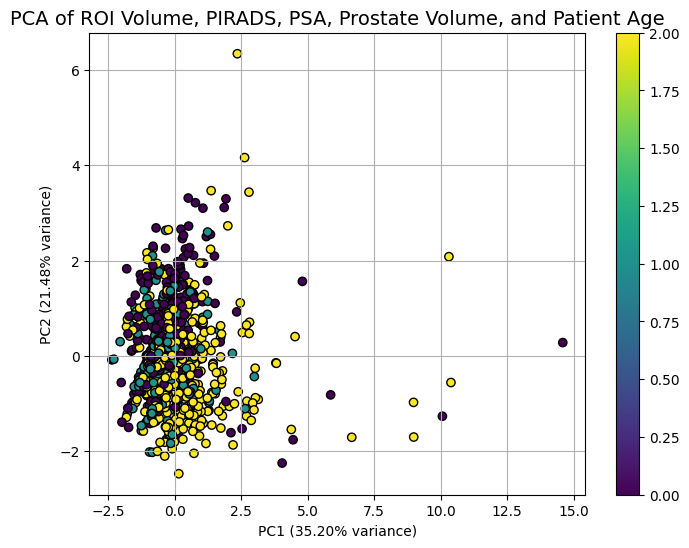

In [6]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create the scatter plot with picker enabled (using a tolerance of 5 points)
sc = ax.scatter(df_all['PC1'], df_all['PC2'],
                c=df_all['Gleason Class'].values,
                edgecolor='k',
                picker=5)

# Add a colorbar and set the plot title and axis labels
plt.colorbar(sc)
ax.set_title('PCA of ROI Volume, PIRADS, PSA, Prostate Volume, and Patient Age', fontsize=14)
ax.set_xlabel(f'PC1 ({explained_variance[0]:.2%} variance)')
ax.set_ylabel(f'PC2 ({explained_variance[1]:.2%} variance)')
ax.grid(True)

# Define a callback function that is triggered when a data point is picked.
def onpick(event):
    # Check if the event comes from our scatter plot
    if event.artist != sc:
        return

    # Retrieve the indices of the picked points (in case of overlapping points)
    ind = event.ind

    # Loop over the selected indices (typically there will be one)
    for i in ind:
        # Create an annotation text using extra data info; customize as desired.
        annotation_text = (f"Index: {i}\n"
                           f"Gleason: {df_all.iloc[i]['Gleason Class']}\n"
                           f"PC1: {df_all.iloc[i]['PC1']:.3f}\n"
                           f"PC2: {df_all.iloc[i]['PC2']:.3f}")
        # Annotate the point with an offset for clarity.
        ax.annotate(annotation_text,
                    (df_all.iloc[i]['PC1'], df_all.iloc[i]['PC2']),
                    textcoords="offset points", xytext=(10, 10),
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
    fig.canvas.draw()  # Redraw the canvas to show annotation

# Connect the pick event handler to the figure
fig.canvas.mpl_connect('pick_event', onpick)

plt.show()


In [8]:
## Model

df_all = df_all.dropna()

print(len(df_all))
print(np.sum(df_all['Gleason Class'].values))
gleason_class_counts = df_all['Gleason Class'].value_counts()
print(gleason_class_counts)
df_all 

df_all.describe()

from sklearn.model_selection import ShuffleSplit

# Set total dataset size
n_dataset = len(df_all)
df_all = df_all.sample(n=n_dataset, random_state=42)

# Set the test and validation set size percentage
test_size_percent = 0.2
validation_size_percent = 0.2

# Only use the first image instance
print('Dataset contains total %d entries' % len(df_all))

n = len(df_all)
X = np.arange(n)

rs_test = ShuffleSplit(n_splits=1, random_state=42, test_size=test_size_percent, train_size=None)
rs_val = ShuffleSplit(n_splits=1, random_state=42, test_size=validation_size_percent/(1-test_size_percent), train_size=None)

temp_idx, test_idx = next(rs_test.split(X=X))
train_idx, val_idx = next(rs_val.split(X=temp_idx))

# Need to convert from relative indices to absolute indices
test_idx = test_idx
val_idx = temp_idx[val_idx]
train_idx = temp_idx[train_idx]

print('X', X)
print('temp_idx', np.sort(temp_idx))
print('test_idx', np.sort(test_idx))
print('train_idx',np.sort(train_idx))
print('val_idx', np.sort(val_idx))

print('Train/Val/Test split size: {}/{}/{}'.format(
    len(train_idx), len(val_idx), len(test_idx)
))

df_train = df_all.iloc[train_idx].copy()
# print(df_train['SITE_ID'].value_counts(normalize=True))
df_val = df_all.iloc[val_idx].copy()
# print(df_val['SITE_ID'].value_counts(normalize=True))
df_test = df_all.iloc[test_idx].copy()
# print(df_test['SITE_ID'].value_counts(normalize=True))


train_data_dict = df_train.to_dict('records')
val_data_dict = df_val.to_dict('records')
test_data_dict = df_test.to_dict('records')

print('Number of training files: ', len(train_data_dict))
print('Number of validation files: ', len(val_data_dict))
print('Number of testing files: ', len(test_data_dict))

SPACING = (0.4,0.4,1)
PATCH_SIZE = (256,256,16)

train_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=['T2','ADC','Prostate Mask','Lesion Mask'], reader='NibabelReader', ensure_channel_first=True),
    # monai.transforms.LoadImaged(keys=['Embedding'], reader='NumpyReader'),
    monai.transforms.ScaleIntensityRanged(keys=['Prostate Mask', 'Lesion Mask'],a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
    monai.transforms.LabelToMaskd(keys=['Prostate Mask', 'Lesion Mask'],select_labels=[1], merge_channels=True),
    monai.transforms.Orientationd(keys=['T2','ADC','Prostate Mask','Lesion Mask'], axcodes='RAS'),
    monai.transforms.Spacingd(keys=['T2','ADC','Prostate Mask','Lesion Mask'], 
             pixdim=SPACING, mode=('bilinear', 'bilinear', 'nearest', 'nearest'), 
             padding_mode=('reflection','reflection','reflection', 'reflection')),
    monai.transforms.ScaleIntensityRangePercentilesd(keys=['T2','ADC'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    # monai.transforms.SpatialPadd(keys=['T2','ADC','Prostate Mask','Lesion Mask'], spatial_size=PATCH_SIZE, mode=('reflect','reflect','reflect','reflect')),    
    # monai.transforms.RandCropByPosNegLabeld(keys=['T2','ADC','Prostate Mask','Lesion Mask'], label_key='Prostate Mask', spatial_size=PATCH_SIZE, pos=1, neg=0, num_samples=1),
    monai.transforms.CenterSpatialCropd(keys=['T2','ADC','Prostate Mask','Lesion Mask'], roi_size=PATCH_SIZE),
    monai.transforms.SpatialPadd(keys=['T2','ADC','Prostate Mask','Lesion Mask'], spatial_size=PATCH_SIZE, mode=('reflect','reflect','reflect','reflect')),    
    # monai.transforms.CenterSpatialCropd(keys=['T2W','ADC','SEGM','SEGM_CA'], roi_size=PATCH_SIZE),      
    monai.transforms.RandFlipd(keys=['T2','ADC','Prostate Mask','Lesion Mask'], prob=0.5, spatial_axis=0),
    monai.transforms.ToTensord(keys=['T2','ADC','Prostate Mask','Lesion Mask','Gleason Class','PSA', 'Prostate Volume', 'ROI Volume', 'PIRADS', 'Patient Age', 'PC1', 'PC2'])
])

test_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=['T2','ADC','Prostate Mask','Lesion Mask'], reader='NibabelReader', ensure_channel_first=True),
    # monai.transforms.LoadImaged(keys=['Embedding'], reader='NumpyReader'),
    monai.transforms.ScaleIntensityRanged(keys=['Prostate Mask', 'Lesion Mask'],a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
    monai.transforms.LabelToMaskd(keys=['Prostate Mask', 'Lesion Mask'],select_labels=[1], merge_channels=True),
    monai.transforms.Orientationd(keys=['T2','ADC','Prostate Mask','Lesion Mask'], axcodes='RAS'),
    monai.transforms.Spacingd(keys=['T2','ADC','Prostate Mask','Lesion Mask'], 
             pixdim=SPACING, mode=('bilinear', 'bilinear', 'nearest', 'nearest'), 
             padding_mode=('reflection','reflection','reflection', 'reflection')),
    monai.transforms.ScaleIntensityRangePercentilesd(keys=['T2','ADC'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    # monai.transforms.SpatialPadd(keys=['T2','ADC','Prostate Mask','Lesion Mask'], spatial_size=PATCH_SIZE, mode=('reflect','reflect','reflect','reflect')),    
    # monai.transforms.RandCropByPosNegLabeld(keys=['T2','ADC','Prostate Mask','Lesion Mask'], label_key='Prostate Mask', spatial_size=PATCH_SIZE, pos=1, neg=0, num_samples=1),
    monai.transforms.CenterSpatialCropd(keys=['T2','ADC','Prostate Mask','Lesion Mask'], roi_size=PATCH_SIZE),
    monai.transforms.SpatialPadd(keys=['T2','ADC','Prostate Mask','Lesion Mask'], spatial_size=PATCH_SIZE, mode=('reflect','reflect','reflect','reflect')),    
    # monai.transforms.CenterSpatialCropd(keys=['T2W','ADC','SEGM','SEGM_CA'], roi_size=PATCH_SIZE),      
    monai.transforms.RandFlipd(keys=['T2','ADC','Prostate Mask','Lesion Mask'], prob=0.5, spatial_axis=0),
    monai.transforms.ToTensord(keys=['T2','ADC','Prostate Mask','Lesion Mask','Gleason Class','PSA', 'Prostate Volume', 'ROI Volume', 'PIRADS', 'Patient Age', 'PC1', 'PC2'])
])

'''
test_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=['T2','ADC','Prostate Mask','Lesion Mask'], reader='NibabelReader', ensure_channel_first=True),
    monai.transforms.ScaleIntensityRanged(keys=['Prostate Mask', 'Lesion Mask'],a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
    monai.transforms.LabelToMaskd(keys=['Prostate Mask', 'Lesion Mask'],select_labels=[1], merge_channels=True),
    monai.transforms.LoadImaged(keys=['Embedding'], reader='NumpyReader'),
    # monai.transforms.AddChanneld(keys=['T2','ADC','Prostate Mask','Lesion Mask']),
    monai.transforms.Orientationd(keys=['T2','ADC','Prostate Mask','Lesion Mask'], axcodes='RAS'),
    monai.transforms.Spacingd(keys=['T2','ADC','Prostate Mask','Lesion Mask'], 
             pixdim=SPACING, mode=('bilinear', 'bilinear', 'nearest', 'nearest'), 
             padding_mode=('reflection','reflection', 'reflection', 'reflection')),
    monai.transforms.ScaleIntensityRangePercentilesd(keys=['T2','ADC'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    # monai.transforms.LabelToMaskd('SEGM_CA',select_labels=[1,2,3,4,5], merge_channels=True),
    monai.transforms.SpatialPadd(keys=['T2','ADC','Prostate Mask','Lesion Mask'], spatial_size=PATCH_SIZE, mode=('reflect','reflect','reflect','reflect')),    
    # monai.transforms.CenterSpatialCropd(keys=['T2','ADC','Prostate Mask','Lesion Mask'], roi_size=PATCH_SIZE),

    # monai.transforms.RandCropByPosNegLabeld(keys=['T2W','ADC','SEGM','SEGM_CA'], label_key='SEGM', spatial_size=PATCH_SIZE, pos=1, neg=0, num_samples=4),
    # Ensure minimum patch ROI size is present
    # SpatialPadd(keys=['IMAGE', 'SEGM'], 
    #             spatial_size=PATCH_SIZE, 
    #             mode=('reflect','reflect')),
    monai.transforms.ToTensord(keys=['T2','ADC','Prostate Mask','Lesion Mask','Gleason Class','Embedding'])
])
'''

val_transforms = test_transforms



921
905
Gleason Class
0    370
2    354
1    197
Name: count, dtype: int64
Dataset contains total 921 entries
X [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218

In [7]:
CACHE_PATH = os.path.join('/tmp/jz766/monai_cache_prostate_pca_benign/')

train_ds = monai.data.PersistentDataset(
    data=train_data_dict, transform=train_transforms, cache_dir=CACHE_PATH
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, collate_fn=list_data_collate)

val_ds = monai.data.PersistentDataset(
    data=val_data_dict, transform=val_transforms, cache_dir=CACHE_PATH
)

val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=4)

test_ds = monai.data.PersistentDataset(
    data=test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

In [8]:
class _routing(nn.Module):

    def __init__(self, len_vector, num_experts, dropout_rate=0.2):
        super(_routing, self).__init__()
        
        self.fc1 = nn.Linear(len_vector,50)
        self.fc2 = nn.Linear(50, num_experts)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x = torch.flatten(x)
        # x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return F.sigmoid(x)

In [9]:
class ClassSegModel(pl.LightningModule):
    def __init__(self):
        super(ClassSegModel, self).__init__()
        self._model = resnet_pca.resnet10(n_input_channels=3, num_classes=3, spatial_dims=3)
        # self.mlp = _routing(len_vector=5, num_experts=5)
        self.class_loss = nn.CrossEntropyLoss(weight=torch.Tensor([0.2548, 0.4787, 0.2664]))
        # self.seg_loss = monai.losses.DiceLoss(include_background=False, to_onehot_y=True)
        # self.seg_loss = monai.losses.GeneralizedDiceLoss(include_background=False, to_onehot_y=True, softmax=True)
        self.val_dice_function = monai.metrics.DiceMetric(include_background=False)
        self.one_hot_transform = monai.transforms.AsDiscrete(to_onehot=2, dim=1)
        # self.validation_step_outputs = []
        # self.training_step_outputs = []

    def forward(self, x, pc1, pc2):
        # psa = psa.reshape((-1,1))
        # age = age.reshape((-1,1))
        # prostate_vol = prostate_vol.reshape((-1,1))
        # roi_vol = roi_vol.reshape((-1,1))
        # pirads = pirads.reshape((-1,1))
        # vector = torch.cat((psa, age, prostate_vol, roi_vol, pirads), 1)
        pc1 = pc1.reshape((-1,1))
        pc2 = pc2.reshape((-1,1))

        b = torch.ones_like(pc1)
        # vector_weights = self.mlp(vector)
        vector_weights = torch.cat((b, pc1, pc2), 1)
        label = self._model((x, vector_weights))       
        return label
    

    def training_step(self, batch, batch_idx):
        # Defines the training logic
        images = batch["T2"]
        adcs = batch["ADC"]
        prostate = batch["Prostate Mask"]
        masks = batch["Lesion Mask"]
        labels = nn.functional.one_hot(batch["Gleason Class"].to(torch.int64), num_classes=3)
        labels = labels.to(torch.float32)
        inputs = torch.cat((images, adcs, prostate), 1)
        
        # psa = batch["PSA"].to(torch.float32)
        # prostate_vol = batch["Prostate Volume"].to(torch.float32)
        # roi_vol = batch["ROI Volume"].to(torch.float32)
        # pirads = batch["PIRADS"].to(torch.float32)
        # age = batch["Patient Age"].to(torch.float32)

        pc1 = batch["PC1"].to(torch.float32)
        pc2 = batch["PC2"].to(torch.float32)

        c = self.forward(inputs, pc1, pc2)
        loss = self.class_loss(c, labels)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        # self.training_step_outputs.append({'loss': loss})
        return {"loss": loss}
        # return loss

    '''
    def on_train_epoch_end(self):
        # Only add the graph at the first epoch
        # Calculate the average loss
        outputs = self.training_step_outputs
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Train/Loss', avg_loss, self.current_epoch)
    '''

    def validation_step(self, batch, batch_idx):
        images = batch["T2"]
        adcs = batch["ADC"]
        prostate = batch["Prostate Mask"]
        masks = batch["Lesion Mask"]
        labels = nn.functional.one_hot(batch["Gleason Class"].to(torch.int64), num_classes=3)
        labels = labels.to(torch.float32)
        # embeddings = torch.randn([4, 1, 128, 8192])
        inputs = torch.cat((images, adcs, prostate), 1)
        
        # psa = batch["PSA"].to(torch.float32)
        # prostate_vol = batch["Prostate Volume"].to(torch.float32)
        # roi_vol = batch["ROI Volume"].to(torch.float32)
        # pirads = batch["PIRADS"].to(torch.float32)
        # age = batch["Patient Age"].to(torch.float32)

        pc1 = batch["PC1"].to(torch.float32)
        pc2 = batch["PC2"].to(torch.float32)

        c = self.forward(inputs, pc1, pc2)
        loss = self.class_loss(c, labels)
#         one_hot = monai.networks.utils.one_hot(labels, num_classes=3)
        
        # self.validation_step_outputs.append({'val_loss': loss, 'val_dice': val_dice})
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return {"val_loss": loss}

    '''
    def on_validation_epoch_end(self):
        # Calculate the average loss
        outputs = self.validation_step_outputs
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_dice = torch.stack([x['val_dice'][0] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Val/Loss', avg_loss, self.current_epoch)
        self.logger.experiment.add_scalar('Val/Dice', avg_dice, self.current_epoch)
        
        self.log('val_loss', avg_loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_dice', avg_dice, on_epoch=True, prog_bar=True, logger=True)
    '''
    def on_epoch_end(self):
        self.log('epoch', float(self.current_epoch), on_step=False, on_epoch=True)

    def configure_optimizers(self):
        # Configure optimizers and optionally learning rate schedulers
        opt = optim.SGD(self.parameters(), lr=1e-3)
        scheduler = {'scheduler': torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=100, gamma=0.98),
                     'name': 'Learning Rate'}
        return [opt], [scheduler]


In [10]:
model_pl = ClassSegModel()

In [11]:
MODEL_PATH = '/gpfs/milgram/project/shung/jz766/LLaVA-Med/notebook/cond_convolution/model_pth_cond_vector_1_pca_prostate_resnet_benign_weighted_bak_v2'

tb_logger = loggers.TensorBoardLogger(os.path.join(MODEL_PATH,'logs'), name='class_seg')
checkpoint_callback = callbacks.ModelCheckpoint(
    dirpath=MODEL_PATH,
    filename='model-{epoch:02d}-{step:04d}',
    # every_n_train_steps=5,  # Set this to the number of training steps after which you want to save the model
    every_n_epochs=1,
    monitor='val_loss',
    save_top_k=2,  # Set this to -1 to save all models after every n steps; be cautious with storage space
    save_last=True,
)

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='epoch')

resume_checkpoint = None
if os.path.exists(os.path.join(MODEL_PATH,'last.ckpt')):
    resume_checkpoint = os.path.join(MODEL_PATH,'last.ckpt')

In [12]:
# torch.multiprocessing.set_start_method('spawn')
trainer = pl.Trainer(
    accelerator='auto',
    devices=[1],
    # precision='16-mixed',
    max_epochs=1000,
    logger=tb_logger,  # Pass the logger to the trainer
    callbacks=[lr_monitor, checkpoint_callback],  # Pass the ModelCheckpoint callback
    num_sanity_val_steps=1,    
    check_val_every_n_epoch=20,
    log_every_n_steps = 20,
    inference_mode=False
)

# Train the models

/gpfs/milgram/project/shung/jz766/conda_envs/llava/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.10 /gpfs/milgram/project/shung/jz766/conda_envs/lla ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# trainer.fit(model_pl, dataloader, ckpt_path='/gpfs/milgram/project/shung/jz766/LLaVA-Med/notebook/model_pth_classseg_v3/model-epoch=23-step=9075.ckpt')
# trainer.fit(model_pl, train_dataloaders=train_loader, val_dataloaders=val_loader, ckpt_path='last')
trainer.fit(model_pl, train_dataloaders=train_loader, val_dataloaders=val_loader, ckpt_path='last')

/gpfs/milgram/project/shung/jz766/conda_envs/llava/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:186: .fit(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded. HINT: Set `ModelCheckpoint(..., save_last=True)`.
Missing logger folder: /gpfs/milgram/project/shung/jz766/LLaVA-Med/notebook/cond_convolution/model_pth_cond_vector_1_pca_prostate_resnet_benign_weighted_bak_v2/logs/class_seg
/gpfs/milgram/project/shung/jz766/conda_envs/llava/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /gpfs/milgram/project/shung/jz766/LLaVA-Med/notebook/cond_convolution/model_pth_cond_vector_1_pca_prostate_resnet_benign_weighted_bak_v2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type             | Params
------------------------------------------------
0 | _model     | ResNet           | 43.2 M
1 | class_loss | CrossEntropy

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [39]:
print('oK')

oK


## Evaluation

In [13]:
from torchmetrics.classification import BinaryAUROC  # Use BinaryAUROC for binary classification
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy


In [14]:
model_path = os.path.join(MODEL_PATH,'model-epoch=59-step=2100.ckpt')
print('Loading saved model from: {}'.format(model_path))

model_pl = ClassSegModel.load_from_checkpoint(model_path)

Loading saved model from: /gpfs/milgram/project/shung/jz766/LLaVA-Med/notebook/cond_convolution/model_pth_cond_vector_1_pca_prostate_resnet_benign_weighted_bak_v2/model-epoch=59-step=2100.ckpt


In [15]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [16]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    prob = prob[0]
    label = label[0]


    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [17]:
def acc(output, label, threshold=0.5):
    prob = output > threshold
    label = label > threshold
    n = prob.size()[0]
    t = 0
    for i in range(n):
        if list(prob[i,...]) == list(label[i,...]):
            t = t+1

    return t/n

In [18]:
# model_pl._model.to(device)

In [19]:
from tqdm import tqdm
model_pl.eval()

all_labels = []
all_preds = []
all_preds_class = []
# auroc = BinaryAUROC()
num_classes = 3

# Initialize metrics
auroc = MulticlassAUROC(num_classes=num_classes)
accuracy = MulticlassAccuracy(num_classes=num_classes)

with torch.no_grad():
    for i, test_data in tqdm(enumerate(test_loader)):
        images = test_data["T2"].to(device)
        adcs = test_data["ADC"].to(device)
        masks = test_data["Prostate Mask"].to(device)
        labels = nn.functional.one_hot(test_data["Gleason Class"].to(torch.int64), num_classes=3).to(device)
        labels = labels.to(torch.float32).to(device)
        inputs = torch.cat((images, adcs, masks), 1)
        psa = test_data["PSA"].to(torch.float32).to(device)
        prostate_vol = test_data["Prostate Volume"].to(torch.float32).to(device)
        roi_vol = test_data["ROI Volume"].to(torch.float32).to(device)
        pirads = test_data["PIRADS"].to(torch.float32).to(device)
        age = test_data["Patient Age"].to(torch.float32).to(device)
        pc1 = test_data["PC1"].to(torch.float32).to(device)
        pc2 = test_data["PC2"].to(torch.float32).to(device)

        logits = model_pl(inputs, pc1, pc2)
        # plt.imshow(argmax[0,0,:,:,8])

        
        probs = F.sigmoid(logits)
        preds_class = torch.argmax(probs, dim=1)
        preds = torch.softmax(logits, dim=1)
        all_labels.extend(test_data["Gleason Class"].cpu().numpy().tolist())
        all_preds_class.extend(preds_class.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())
        # preds = probs > 0.5
        # print(probs)
        print(preds_class)
        # print(torch.argmax(labels, dim=1))
        print(labels)
        # print(F_score(probs, labels))
        # print(acc(probs, labels))
        # dice_score = dice_coefficient(prbeds, masks)  # Ensure both inputs to dice_coefficient are float tensors
        # total_dice += dice_score.item()

        
all_labels_tensor = torch.tensor(all_labels)
all_preds_tensor = torch.tensor(all_preds)

# auc = auroc(all_preds_tensor, all_labels_tensor)
# print(f"AUC: {auc.item()}")

1it [00:06,  6.99s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([1], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([1], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


7it [00:12,  1.38s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


11it [00:18,  1.30s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([1], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


13it [00:24,  1.86s/it]

metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


16it [00:28,  1.61s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')


17it [00:30,  1.66s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


19it [00:31,  1.31s/it]

metatensor([0], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')


20it [00:33,  1.53s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


21it [00:35,  1.63s/it]

metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


23it [00:36,  1.24s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


24it [00:39,  1.55s/it]

metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


25it [00:41,  1.66s/it]

metatensor([1], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


27it [00:42,  1.24s/it]

metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


28it [00:45,  1.51s/it]

metatensor([1], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


29it [00:47,  1.66s/it]

metatensor([1], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


31it [00:48,  1.22s/it]

metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


32it [00:51,  1.49s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


33it [00:53,  1.65s/it]

metatensor([1], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')


35it [00:54,  1.20s/it]

metatensor([1], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')


36it [00:56,  1.49s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


37it [01:00,  1.96s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


40it [01:02,  1.36s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')


43it [01:06,  1.16s/it]

metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([1], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


44it [01:08,  1.42s/it]

metatensor([0], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


45it [01:11,  1.85s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


48it [01:14,  1.35s/it]

metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


49it [01:17,  1.74s/it]

metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


52it [01:20,  1.33s/it]

metatensor([1], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


53it [01:24,  1.89s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([1], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


56it [01:26,  1.26s/it]

metatensor([0], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')


57it [01:30,  1.82s/it]

metatensor([2], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([1], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


60it [01:31,  1.20s/it]

metatensor([0], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


61it [01:36,  1.79s/it]

metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


64it [01:37,  1.22s/it]

metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


65it [01:42,  1.80s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


68it [01:43,  1.20s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


69it [01:48,  1.75s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')


71it [01:48,  1.32s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


72it [01:49,  1.13s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')


73it [01:53,  1.86s/it]

metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')


75it [01:54,  1.26s/it]

metatensor([2], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


76it [01:54,  1.09s/it]

metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


77it [01:59,  1.96s/it]

metatensor([2], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([1], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


79it [01:59,  1.24s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


80it [02:00,  1.08s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')


83it [02:05,  1.23s/it]

metatensor([1], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


84it [02:06,  1.11s/it]

metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


85it [02:10,  1.97s/it]

metatensor([0], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


87it [02:11,  1.22s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


88it [02:11,  1.10s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


89it [02:16,  2.00s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')


91it [02:17,  1.38s/it]

metatensor([1], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


93it [02:22,  1.72s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')


95it [02:23,  1.30s/it]

metatensor([0], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


97it [02:27,  1.65s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


99it [02:30,  1.48s/it]

metatensor([0], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


101it [02:33,  1.56s/it]

metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([1], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


103it [02:36,  1.46s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


105it [02:39,  1.54s/it]

metatensor([2], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


107it [02:41,  1.43s/it]

metatensor([0], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


109it [02:44,  1.47s/it]

metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([1], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')


111it [02:47,  1.38s/it]

metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')


113it [02:50,  1.48s/it]

metatensor([1], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


115it [02:53,  1.38s/it]

metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


117it [02:56,  1.50s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


119it [02:59,  1.41s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


121it [03:02,  1.54s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


123it [03:04,  1.38s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


125it [03:08,  1.52s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


127it [03:10,  1.35s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


129it [03:14,  1.53s/it]

metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([1], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


131it [03:15,  1.28s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')


133it [03:19,  1.55s/it]

metatensor([0], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


135it [03:21,  1.26s/it]

metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


137it [03:27,  1.79s/it]

metatensor([0], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


141it [03:32,  1.60s/it]

metatensor([0], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


145it [03:38,  1.57s/it]

metatensor([1], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([1], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


149it [03:45,  1.60s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


153it [03:51,  1.55s/it]

metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


157it [03:56,  1.49s/it]

metatensor([0], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([1], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([1], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


161it [04:02,  1.46s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([1], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


165it [04:07,  1.43s/it]

metatensor([0], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')


169it [04:13,  1.42s/it]

metatensor([1], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


173it [04:20,  1.53s/it]

metatensor([1], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


177it [04:26,  1.49s/it]

metatensor([0], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')
metatensor([1], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')


181it [04:31,  1.44s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([1], device='cuda:1')
metatensor([[0., 0., 1.]], device='cuda:1')
metatensor([2], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')
metatensor([0], device='cuda:1')
metatensor([[1., 0., 0.]], device='cuda:1')


185it [04:36,  1.50s/it]

metatensor([2], device='cuda:1')
metatensor([[0., 1., 0.]], device='cuda:1')


In [20]:
auc = auroc(all_preds_tensor, all_labels_tensor)
print(f"AUC: {auc.item()}")

# Calculate Accuracy using torchmetrics
accuracy_score = accuracy(all_preds_tensor, all_labels_tensor)
print(f"Accuracy: {accuracy_score.item()}")


AUC: 0.7044350504875183
Accuracy: 0.5154938697814941


In [21]:
per_class_accuracy = MulticlassAccuracy(num_classes=num_classes, average=None)
per_class_accuracy_scores = per_class_accuracy(all_preds_tensor, all_labels_tensor)
for class_idx, acc in enumerate(per_class_accuracy_scores):
    print(f"Accuracy for class {class_idx}: {acc.item()}")


Accuracy for class 0: 0.6571428775787354
Accuracy for class 1: 0.20512820780277252
Accuracy for class 2: 0.6842105388641357


In [27]:
from sklearn.metrics import roc_auc_score
for class_idx in range(num_classes):
    # Create binary labels for the current class
    binary_labels = (all_labels_tensor == class_idx).int()
    
    # Get the predictions for the current class vs all other classes
    binary_preds = all_preds_tensor[:, class_idx]
    
    # Calculate AUC for the current class
    class_auc = roc_auc_score(binary_labels.numpy(), binary_preds.numpy())
    print(f"AUC for class {class_idx} vs all: {class_auc}")


AUC for class 0 vs all: 0.9298136645962733
AUC for class 1 vs all: 0.8912890762205831
AUC for class 2 vs all: 0.9054804442298406


In [ ]:
c0 = 0
c1 = 0
for i in range(len(all_labels)):
    if all_labels[i] == 0:
        if all_preds_class[i] == 0:
            c0 = c0 + 1
    else:
        if all_preds_class[i] == 1:
            c1 = c1 + 1

print(c0)
print(c1)
print(np.sum(all_labels))

In [34]:
all_preds

[metatensor(0.9226),
 metatensor(0.1014),
 metatensor(0.2814),
 metatensor(0.2416),
 metatensor(0.1826),
 metatensor(0.9629),
 metatensor(0.9625),
 metatensor(0.8774),
 metatensor(0.7231),
 metatensor(0.8653),
 metatensor(0.9246),
 metatensor(0.8329),
 metatensor(0.7018),
 metatensor(0.7455),
 metatensor(0.7367),
 metatensor(0.7541),
 metatensor(0.7811),
 metatensor(0.8299),
 metatensor(0.3992),
 metatensor(0.2286),
 metatensor(0.8690),
 metatensor(0.8957),
 metatensor(0.7503),
 metatensor(0.9579),
 metatensor(0.9686),
 metatensor(0.5405),
 metatensor(0.2858),
 metatensor(0.2959),
 metatensor(0.6961),
 metatensor(0.7847),
 metatensor(0.4341),
 metatensor(0.5280),
 metatensor(0.8899),
 metatensor(0.6847),
 metatensor(0.2726),
 metatensor(0.4274),
 metatensor(0.9250),
 metatensor(0.3880),
 metatensor(0.1733),
 metatensor(0.6796),
 metatensor(0.2316),
 metatensor(0.3760),
 metatensor(0.6123),
 metatensor(0.6991),
 metatensor(0.5443),
 metatensor(0.8795),
 metatensor(0.7781),
 metatensor(0

## Check activation

In [22]:
from tqdm import tqdm
model_pl.eval()
with torch.no_grad():
    for i, test_data in tqdm(enumerate(test_loader)):
        psa = test_data["PSA"].to(torch.float32).to(device)
        prostate_vol = test_data["Prostate Volume"].to(torch.float32).to(device)
        roi_vol = test_data["ROI Volume"].to(torch.float32).to(device)
        pirads = test_data["PIRADS"].to(torch.float32).to(device)
        age = test_data["Patient Age"].to(torch.float32).to(device)
        psa = psa.reshape((-1,1))
        age = age.reshape((-1,1))
        prostate_vol = prostate_vol.reshape((-1,1))
        roi_vol = roi_vol.reshape((-1,1))
        pirads = pirads.reshape((-1,1))
        vector = torch.cat((psa, age, prostate_vol, roi_vol, pirads), 1)
        print(vector)
        vector_weights = model_pl._model.mlp(vector).cpu().numpy()
        print(vector_weights)

        # mpl_activation = model_pl._model.mlp(psa).view(16,16).cpu().numpy()
        '''
        psa_activation = model_pl._model.psa_mlp(psa).view(16,16).cpu().numpy()
        prostate_vol = model_pl._model.prostate_vol_mlp(prostate_vol).view(16,16).cpu().numpy()
        roi_vol = model_pl._model.roi_vol_mlp(roi_vol).view(16,16).cpu().numpy()
        pirads = model_pl._model.pirads_mlp(pirads).view(16,16).cpu().numpy()


        plt.figure('check', (9, 4))
        plt.subplot(1, 4, 1)
        plt.title('PSA')
        plt.imshow(psa_activation)
        plt.subplot(1, 4, 2)
        plt.title('Prostate Vol')
        plt.imshow(prostate_vol)
        plt.subplot(1, 4, 3)
        plt.title('ROI Vol')
        plt.imshow(roi_vol)
        # plt.colorbar()
        plt.subplot(1, 4, 4)
        plt.title('PIRADS')  
        plt.imshow(pirads)

        plt.show()
        '''

1it [00:01,  1.17s/it]

metatensor([[ 1.6000, 74.0000, 18.8399,  0.6626,  5.0000]], device='cuda:0')
[[1.8617253e-05 9.9999988e-01 9.9453461e-01 9.1768369e-02 9.9999654e-01]]
metatensor([[ 5.5000, 63.0000, 20.1251,  0.1101,  4.0000]], device='cuda:0')
[[2.4032050e-04 9.9999905e-01 9.7478831e-01 8.1915267e-02 9.9994397e-01]]
metatensor([[ 1.7600, 66.0000, 46.2503,  0.1995,  4.0000]], device='cuda:0')
[[1.0873080e-04 9.9999940e-01 6.6126519e-01 2.7196023e-03 9.9999571e-01]]
metatensor([[12.7000, 67.0000, 33.5490,  0.2461,  4.0000]], device='cuda:0')
[[6.2340230e-04 9.9999976e-01 9.1654384e-01 1.7495207e-02 9.9984324e-01]]


8it [00:01,  5.47it/s]

metatensor([[ 7.6000, 73.0000, 59.5013,  0.7284,  5.0000]], device='cuda:0')
[[6.0276103e-05 1.0000000e+00 4.4860622e-01 2.8950069e-04 9.9999487e-01]]
metatensor([[ 8.0000, 63.0000, 40.2020,  1.9847,  4.0000]], device='cuda:0')
[[5.0248514e-04 9.9999964e-01 7.2987556e-01 5.7078148e-03 9.9993992e-01]]
metatensor([[ 4.5000, 59.0000, 41.7807,  0.1028,  3.0000]], device='cuda:0')
[[4.6303900e-04 9.9999774e-01 6.2761348e-01 4.8191929e-03 9.9996591e-01]]
metatensor([[10.6000, 76.0000, 37.2282,  0.7345,  4.0000]], device='cuda:0')
[[1.2697316e-04 1.0000000e+00 9.4185603e-01 1.6617635e-02 9.9998283e-01]]


10it [00:02,  3.94it/s]

metatensor([[ 6.5000, 63.0000, 36.3215,  0.1081,  4.0000]], device='cuda:0')
[[3.9437501e-04 9.9999928e-01 8.0700690e-01 1.1954788e-02 9.9995339e-01]]
metatensor([[ 3.0000, 63.0000, 61.5302,  1.1463,  3.0000]], device='cuda:0')
[[8.5722269e-05 9.9999928e-01 1.8773980e-01 1.7348722e-04 9.9999273e-01]]
metatensor([[ 2.1000, 62.0000, 41.3760,  0.2530,  3.0000]], device='cuda:0')
[[2.1154762e-04 9.9999857e-01 6.8971342e-01 6.3720066e-03 9.9998987e-01]]
metatensor([[ 6.1000, 61.0000, 24.6570,  0.3785,  4.0000]], device='cuda:0')
[[4.0391085e-04 9.9999893e-01 9.5078975e-01 6.1837260e-02 9.9990666e-01]]


13it [00:03,  3.44it/s]

metatensor([[ 11.9000,  66.0000, 131.7915,   0.9574,   2.0000]], device='cuda:0')
[[1.1455040e-06 9.9999988e-01 3.3854925e-05 1.5021218e-09 9.9992883e-01]]
metatensor([[4.3000e+00, 6.2000e+01, 9.4002e+01, 4.8624e-02, 3.0000e+00]],
       device='cuda:0')
[[9.6554495e-06 9.9999869e-01 2.3378949e-03 1.1020693e-06 9.9998331e-01]]
metatensor([[13.5000, 67.0000, 30.4349,  0.7470,  5.0000]], device='cuda:0')
[[6.9886813e-04 9.9999988e-01 9.4445449e-01 2.2004927e-02 9.9974614e-01]]
metatensor([[14.4000, 76.0000, 63.5420,  6.3596,  5.0000]], device='cuda:0')
[[1.06493535e-04 1.00000000e+00 3.89990211e-01 1.69441118e-04
  9.99982953e-01]]


17it [00:04,  3.78it/s]

metatensor([[ 1.7000, 65.0000, 21.4109,  2.2737,  4.0000]], device='cuda:0')
[[8.8059736e-05 9.9999952e-01 9.8196113e-01 9.8171078e-02 9.9998736e-01]]
metatensor([[ 9.9000, 67.0000, 30.7431,  3.4033,  5.0000]], device='cuda:0')
[[3.9125659e-04 9.9999988e-01 9.4109303e-01 2.7670385e-02 9.9992108e-01]]
metatensor([[ 2.0000, 65.0000, 28.2344,  0.1911,  3.0000]], device='cuda:0')
[[1.1420174e-04 9.9999905e-01 9.5135975e-01 5.2030522e-02 9.9998927e-01]]
metatensor([[ 9.2000, 53.0000, 38.9703,  0.3894,  4.0000]], device='cuda:0')
[[0.00189599 0.99999547 0.5820333  0.00565697 0.999564  ]]


21it [00:05,  3.97it/s]

metatensor([[ 6.2000, 70.0000, 38.5472,  0.4478,  3.0000]], device='cuda:0')
[[1.4226585e-04 9.9999988e-01 8.6778075e-01 1.3613259e-02 9.9998939e-01]]
metatensor([[ 8.5000, 60.0000, 34.5732,  0.9516,  4.0000]], device='cuda:0')
[[8.2880614e-04 9.9999917e-01 8.0224866e-01 1.3884478e-02 9.9985588e-01]]
metatensor([[10.0000, 72.0000, 53.5130,  0.3136,  4.0000]], device='cuda:0')
[[1.4596664e-04 9.9999988e-01 5.7870048e-01 9.5686817e-04 9.9998796e-01]]
metatensor([[ 9.3400, 71.0000, 43.5686,  0.1041,  3.0000]], device='cuda:0')
[[1.9806104e-04 9.9999988e-01 7.8217065e-01 5.5865203e-03 9.9998307e-01]]


25it [00:06,  4.11it/s]

metatensor([[ 8.1000, 56.0000, 37.1653,  0.3054,  3.0000]], device='cuda:0')
[[0.00129489 0.99999714 0.6730835  0.00864033 0.9998018 ]]
metatensor([[ 6.6000, 59.0000, 31.1644,  0.2469,  1.0000]], device='cuda:0')
[[7.0009136e-04 9.9999750e-01 8.6758387e-01 3.9207406e-02 9.9992263e-01]]
metatensor([[ 8.8000, 72.0000, 70.4028,  0.2860,  2.0000]], device='cuda:0')
[[4.6001191e-05 9.9999988e-01 1.2880261e-01 6.9339832e-05 9.9999416e-01]]
metatensor([[ 1.1000, 71.0000, 45.8997,  0.3090,  4.0000]], device='cuda:0')
[[5.0713683e-05 9.9999976e-01 7.4518943e-01 3.7570072e-03 9.9999845e-01]]


29it [00:07,  4.16it/s]

metatensor([[ 7.6500, 60.0000, 17.0165,  0.1187,  4.0000]], device='cuda:0')
[[5.3502526e-04 9.9999845e-01 9.7419554e-01 9.0188056e-02 9.9982786e-01]]
metatensor([[13.3000, 58.0000, 62.6911,  0.4311,  3.0000]], device='cuda:0')
[[4.1861986e-04 9.9999833e-01 7.8115255e-02 1.6984763e-04 9.9953079e-01]]
metatensor([[ 3.2000, 69.0000, 30.6216,  0.1015,  3.0000]], device='cuda:0')
[[8.0431644e-05 9.9999964e-01 9.5254439e-01 4.1999489e-02 9.9999297e-01]]
metatensor([[17.3000, 63.0000, 25.0276,  2.1504,  4.0000]], device='cuda:0')
[[0.00221264 0.99999964 0.9569779  0.03392848 0.9989214 ]]


33it [00:08,  4.24it/s]

metatensor([[ 2.7000, 65.0000, 10.5756,  0.1394,  4.0000]], device='cuda:0')
[[6.8614710e-05 9.9999905e-01 9.9486154e-01 1.5842463e-01 9.9997723e-01]]
metatensor([[ 3.6000, 62.0000, 28.6508,  0.2732,  1.0000]], device='cuda:0')
[[2.3783384e-04 9.9999797e-01 9.2528939e-01 6.2565729e-02 9.9997962e-01]]
metatensor([[ 5.1000, 61.0000, 36.9274,  0.2849,  4.0000]], device='cuda:0')
[[4.0726920e-04 9.9999893e-01 7.5985020e-01 1.0076174e-02 9.9995756e-01]]
metatensor([[1.2000e+01, 6.7000e+01, 3.0913e+01, 4.9111e-02, 4.0000e+00]],
       device='cuda:0')
[[5.4828404e-04 9.9999976e-01 9.4066608e-01 2.6873827e-02 9.9984848e-01]]


37it [00:09,  4.27it/s]

metatensor([[ 5.4000, 71.0000, 39.0136,  2.3925,  5.0000]], device='cuda:0')
[[1.07744694e-04 9.99999881e-01 8.65051866e-01 9.84974485e-03
  9.99991179e-01]]
metatensor([[ 2.9800, 74.0000, 18.1483,  0.1705,  3.0000]], device='cuda:0')
[[2.08220335e-05 9.99999881e-01 9.94342804e-01 1.12109445e-01
  9.99996781e-01]]
metatensor([[ 20.8000,  75.0000, 182.1486,   0.7619,   4.0000]], device='cuda:0')
[[3.3954251e-08 1.0000000e+00 3.0288521e-07 4.5459101e-13 9.9994576e-01]]
metatensor([[20.4000, 73.0000, 43.4457,  1.3155,  4.0000]], device='cuda:0')
[[7.7005540e-04 1.0000000e+00 8.1314325e-01 4.4731037e-03 9.9974102e-01]]


41it [00:10,  4.26it/s]

metatensor([[ 4.7000, 67.0000, 45.5803,  0.0955,  3.0000]], device='cuda:0')
[[1.5838502e-04 9.9999952e-01 6.7931312e-01 3.5800049e-03 9.9999213e-01]]
metatensor([[ 6.0000, 62.0000, 46.2106,  0.1149,  3.0000]], device='cuda:0')
[[3.4153019e-04 9.9999905e-01 5.6737566e-01 2.4004697e-03 9.9997342e-01]]
metatensor([[13.0000, 57.0000, 41.6937,  0.2786,  3.0000]], device='cuda:0')
[[0.00202934 0.9999982  0.549611   0.00513857 0.9994553 ]]
metatensor([[11.6000, 71.0000, 34.1829,  0.1514,  3.0000]], device='cuda:0')
[[2.9485507e-04 9.9999988e-01 9.3865484e-01 2.3449993e-02 9.9994922e-01]]


45it [00:11,  4.24it/s]

metatensor([[18.9000, 69.0000, 35.6803,  0.3786,  3.0000]], device='cuda:0')
[[0.00129487 0.9999999  0.89873457 0.01296147 0.9995333 ]]
metatensor([[15.1000, 67.0000, 55.2829,  0.0801,  3.0000]], device='cuda:0')
[[4.4525432e-04 9.9999976e-01 3.5554910e-01 8.3160389e-04 9.9987435e-01]]
metatensor([[ 6.2000, 62.0000, 65.1605,  0.3046,  3.0000]], device='cuda:0')
[[9.9730125e-05 9.9999893e-01 1.0868811e-01 9.9832410e-05 9.9997723e-01]]
metatensor([[ 6.4000, 74.0000, 83.9551,  0.3619,  3.0000]], device='cuda:0')
[[1.0194292e-05 9.9999988e-01 3.2588098e-02 6.9737789e-06 9.9999797e-01]]


49it [00:12,  4.32it/s]

metatensor([[ 6.4000, 67.0000, 47.0746,  0.9842,  1.0000]], device='cuda:0')
[[2.1591134e-04 9.9999964e-01 6.3021797e-01 3.7092681e-03 9.9999070e-01]]
metatensor([[ 3.7000, 69.0000, 23.9772,  0.6941,  4.0000]], device='cuda:0')
[[7.4183554e-05 9.9999976e-01 9.7975218e-01 7.0798576e-02 9.9998927e-01]]
metatensor([[ 8.2000, 68.0000, 69.2866,  1.4246,  5.0000]], device='cuda:0')
[[5.1083836e-05 9.9999988e-01 1.2384026e-01 4.9348990e-05 9.9998510e-01]]
metatensor([[ 5.0000, 59.0000, 54.8645,  0.1231,  4.0000]], device='cuda:0')
[[2.1498199e-04 9.9999833e-01 2.7540004e-01 4.2279714e-04 9.9996626e-01]]


53it [00:13,  4.35it/s]

metatensor([[ 3.9000, 75.0000, 66.4667,  3.7222,  5.0000]], device='cuda:0')
[[2.4568651e-05 1.0000000e+00 2.7981117e-01 8.5607819e-05 9.9999893e-01]]
metatensor([[ 7.3000, 71.0000, 48.8334,  0.3574,  4.0000]], device='cuda:0')
[[1.3498389e-04 9.9999988e-01 6.7688757e-01 1.8873285e-03 9.9999142e-01]]
metatensor([[ 7.6000, 56.0000, 22.7041,  0.1278,  4.0000]], device='cuda:0')
[[0.00112029 0.999997   0.9375772  0.06825083 0.99961865]]
metatensor([[ 5.6000, 71.0000, 28.9440,  0.1288,  3.0000]], device='cuda:0')
[[8.1754035e-05 9.9999976e-01 9.6637797e-01 5.0519112e-02 9.9999034e-01]]


57it [00:13,  4.35it/s]

metatensor([[ 8.0000, 57.0000, 61.8894,  0.1337,  4.0000]], device='cuda:0')
[[2.1293809e-04 9.9999738e-01 9.8951109e-02 1.4135957e-04 9.9987555e-01]]
metatensor([[ 19.6000,  63.0000, 114.1135,   0.2429,   4.0000]], device='cuda:0')
[[1.3009102e-05 9.9999976e-01 2.9845771e-04 1.9789933e-08 9.9906665e-01]]
metatensor([[ 7.6000, 62.0000, 30.5279,  0.2438,  3.0000]], device='cuda:0')
[[5.4110878e-04 9.9999905e-01 9.0344411e-01 3.5630062e-02 9.9990857e-01]]
metatensor([[ 3.8000, 74.0000, 52.1022,  0.1035,  4.0000]], device='cuda:0')
[[4.9102164e-05 9.9999988e-01 6.6203797e-01 1.3505889e-03 9.9999845e-01]]


61it [00:14,  4.38it/s]

metatensor([[10.5000, 65.0000, 65.5775,  0.4809,  3.0000]], device='cuda:0')
[[1.30024244e-04 9.99999523e-01 1.18633784e-01 1.19309720e-04
  9.99953866e-01]]
metatensor([[1.0900e+01, 6.8000e+01, 3.9981e+01, 4.1624e-02, 3.0000e+00]],
       device='cuda:0')
[[3.9661169e-04 9.9999976e-01 8.1922752e-01 8.6914394e-03 9.9994874e-01]]
metatensor([[ 4.7000, 66.0000, 52.6013,  0.9396,  4.0000]], device='cuda:0')
[[1.3055251e-04 9.9999964e-01 4.7844169e-01 7.7785063e-04 9.9999130e-01]]
metatensor([[6.0000e+00, 6.8000e+01, 5.6767e+01, 6.3896e-02, 3.0000e+00]],
       device='cuda:0')
[[1.01845595e-04 9.99999762e-01 3.90516192e-01 4.84985678e-04
  9.99992847e-01]]


65it [00:15,  4.43it/s]

metatensor([[ 8.6000, 67.0000, 48.3902,  0.1410,  4.0000]], device='cuda:0')
[[2.5457353e-04 9.9999976e-01 6.2172914e-01 1.8514249e-03 9.9997699e-01]]
metatensor([[ 5.6000, 83.0000, 22.2754,  1.1682,  5.0000]], device='cuda:0')
[[1.0362039e-05 1.0000000e+00 9.9556196e-01 6.2086858e-02 9.9999833e-01]]
metatensor([[ 6.6000, 72.0000, 30.0575,  1.0279,  4.0000]], device='cuda:0')
[[9.1061229e-05 9.9999988e-01 9.6589804e-01 4.0337637e-02 9.9998760e-01]]
metatensor([[ 5.9000, 68.0000, 33.3660,  0.1477,  4.0000]], device='cuda:0')
[[1.7164058e-04 9.9999976e-01 9.1387922e-01 2.5825135e-02 9.9997830e-01]]


69it [00:16,  4.38it/s]

metatensor([[11.0000, 67.0000, 87.8193, 13.8380,  4.0000]], device='cuda:0')
[[3.3477401e-05 1.0000000e+00 1.6706303e-02 2.0221944e-06 9.9997377e-01]]
metatensor([[ 3.2000, 70.0000, 34.7634,  0.1174,  3.0000]], device='cuda:0')
[[7.7223172e-05 9.9999976e-01 9.1366643e-01 2.4972081e-02 9.9999464e-01]]
metatensor([[ 1.2000, 69.0000, 34.4947,  9.2494,  5.0000]], device='cuda:0')
[[6.0739727e-05 1.0000000e+00 9.2582679e-01 1.6585702e-02 9.9999762e-01]]
metatensor([[ 5.3000, 60.0000, 62.0220,  1.3195,  5.0000]], device='cuda:0')
[[1.1997644e-04 9.9999893e-01 1.4362437e-01 1.2429610e-04 9.9996674e-01]]


73it [00:17,  4.34it/s]

metatensor([[1.7800e+01, 7.1000e+01, 1.5220e+02, 1.4830e-01, 4.0000e+00]],
       device='cuda:0')
[[3.2083696e-07 1.0000000e+00 5.7859897e-06 5.0333467e-11 9.9990988e-01]]
metatensor([[ 7.8000, 62.0000, 36.4811,  0.6385,  4.0000]], device='cuda:0')
[[5.5482250e-04 9.9999940e-01 7.8950894e-01 1.0915514e-02 9.9992239e-01]]
metatensor([[ 5.5000, 62.0000, 59.8484,  0.1641,  4.0000]], device='cuda:0')
[[1.2515085e-04 9.9999905e-01 2.0904706e-01 2.0717786e-04 9.9997890e-01]]
metatensor([[ 3.8000, 70.0000, 47.5546,  0.0701,  3.0000]], device='cuda:0')
[[8.9736488e-05 9.9999976e-01 6.8808293e-01 2.9953115e-03 9.9999666e-01]]


77it [00:18,  4.33it/s]

metatensor([[28.8000, 58.0000, 26.1310, 10.1916,  4.0000]], device='cuda:0')
[[0.01936034 0.99999976 0.9157692  0.02666999 0.97493726]]
metatensor([[10.6000, 67.0000, 22.7628,  0.7674,  3.0000]], device='cuda:0')
[[3.3303641e-04 9.9999964e-01 9.7263789e-01 6.6680133e-02 9.9992239e-01]]
metatensor([[ 3.1000, 65.0000, 24.9555,  0.5537,  5.0000]], device='cuda:0')
[[1.3308799e-04 9.9999952e-01 9.7075677e-01 6.0293037e-02 9.9997628e-01]]
metatensor([[ 9.5000, 73.0000, 75.6715,  4.3095,  4.0000]], device='cuda:0')
[[2.8498938e-05 1.0000000e+00 9.0932988e-02 2.1262184e-05 9.9999344e-01]]


81it [00:19,  4.28it/s]

metatensor([[ 2.2000, 46.0000, 31.0547,  0.1415,  3.0000]], device='cuda:0')
[[0.00201548 0.9999603  0.6477464  0.01811196 0.9997484 ]]
metatensor([[ 6.6000, 60.0000, 68.2031,  0.9362,  4.0000]], device='cuda:0')
[[9.2771937e-05 9.9999869e-01 6.2518314e-02 5.3163927e-05 9.9995601e-01]]
metatensor([[ 6.2000, 74.0000, 56.8906,  0.5880,  4.0000]], device='cuda:0')
[[5.7766723e-05 9.9999988e-01 5.2872950e-01 5.1858736e-04 9.9999726e-01]]
metatensor([[ 8.2000, 65.0000, 40.9058,  0.2260,  3.0000]], device='cuda:0')
[[3.8462525e-04 9.9999952e-01 7.4124283e-01 6.7408606e-03 9.9996138e-01]]


85it [00:20,  4.23it/s]

metatensor([[7.0000e+00, 5.7000e+01, 6.4917e+01, 1.2317e-02, 3.0000e+00]],
       device='cuda:0')
[[1.5964104e-04 9.9999690e-01 6.5709896e-02 9.4331277e-05 9.9991643e-01]]
metatensor([[ 4.6000, 74.0000, 55.2406,  0.1510,  4.0000]], device='cuda:0')
[[5.0801489e-05 9.9999988e-01 5.7379723e-01 6.8825146e-04 9.9999809e-01]]
metatensor([[ 7.3000, 74.0000, 49.7624,  0.5716,  5.0000]], device='cuda:0')
[[8.9672321e-05 1.0000000e+00 7.1037292e-01 1.5239523e-03 9.9999428e-01]]
metatensor([[ 6.6000, 71.0000, 54.7601,  1.8278,  4.0000]], device='cuda:0')
[[9.7603377e-05 9.9999988e-01 5.2436090e-01 6.5532303e-04 9.9999452e-01]]


89it [00:21,  4.25it/s]

metatensor([[22.0000, 71.0000, 48.3481,  3.2100,  5.0000]], device='cuda:0')
[[0.00106147 1.         0.67624193 0.00203025 0.99939954]]
metatensor([[ 5.7000, 64.0000, 57.9983,  0.4819,  4.0000]], device='cuda:0')
[[1.2395557e-04 9.9999952e-01 2.8962249e-01 2.9675389e-04 9.9998498e-01]]
metatensor([[ 6.2000, 57.0000, 42.8579,  0.6040,  3.0000]], device='cuda:0')
[[6.9762638e-04 9.9999750e-01 5.5669826e-01 3.5336677e-03 9.9992526e-01]]
metatensor([[9.6000e+00, 6.4000e+01, 3.8886e+01, 6.0323e-02, 3.0000e+00]],
       device='cuda:0')
[[5.5540027e-04 9.9999952e-01 7.7269012e-01 9.1088619e-03 9.9992716e-01]]


93it [00:22,  4.33it/s]

metatensor([[12.7000, 49.0000, 20.4772,  4.0170,  5.0000]], device='cuda:0')
[[0.00752746 0.99999535 0.9094796  0.05193381 0.99525416]]
metatensor([[ 1.2000, 57.0000, 49.4777,  1.0956,  5.0000]], device='cuda:0')
[[2.3562912e-04 9.9999762e-01 3.6853325e-01 8.6089945e-04 9.9997807e-01]]
metatensor([[ 5.4000, 73.0000, 70.5348,  0.3008,  4.0000]], device='cuda:0')
[[2.3800603e-05 9.9999988e-01 1.6645163e-01 4.8652186e-05 9.9999785e-01]]
metatensor([[7.9000e+00, 6.5000e+01, 3.8094e+01, 1.6688e-02, 3.0000e+00]],
       device='cuda:0')
[[3.7256486e-04 9.9999952e-01 8.0755806e-01 1.1316689e-02 9.9996006e-01]]


97it [00:23,  4.36it/s]

metatensor([[10.3000, 70.0000, 31.0126,  2.1560,  5.0000]], device='cuda:0')
[[2.6938130e-04 9.9999988e-01 9.5394373e-01 2.8928271e-02 9.9994266e-01]]
metatensor([[14.2000, 65.0000, 28.3612,  1.8537,  4.0000]], device='cuda:0')
[[0.0010311  0.99999976 0.9480866  0.03008793 0.99966156]]
metatensor([[ 6.2000, 78.0000, 37.1691,  1.5175,  0.0000]], device='cuda:0')
[[3.8612430e-05 1.0000000e+00 9.5220673e-01 3.0786453e-02 9.9999857e-01]]
metatensor([[ 5.2000, 75.0000, 80.7437,  1.7251,  5.0000]], device='cuda:0')
[[9.3364733e-06 1.0000000e+00 6.0752761e-02 9.2987530e-06 9.9999845e-01]]


102it [00:24,  4.65it/s]

metatensor([[10.9000, 53.0000, 54.0842,  0.1210,  3.0000]], device='cuda:0')
[[8.3948026e-04 9.9999416e-01 1.4478351e-01 5.7846104e-04 9.9937636e-01]]
metatensor([[1.9000e+00, 6.4000e+01, 3.2778e+01, 6.1880e-02, 4.0000e+00]],
       device='cuda:0')
[[1.5264981e-04 9.9999917e-01 8.7853235e-01 2.4348551e-02 9.9998641e-01]]
metatensor([[ 2.6000, 66.0000, 21.7702,  0.6938,  5.0000]], device='cuda:0')
[[9.616989e-05 9.999995e-01 9.810044e-01 7.574640e-02 9.999815e-01]]
metatensor([[14.6000, 72.0000, 34.1758,  0.5768,  4.0000]], device='cuda:0')
[[4.2013123e-04 9.9999988e-01 9.4532287e-01 1.6986305e-02 9.9989307e-01]]


107it [00:25,  5.25it/s]

metatensor([[ 6.5000, 69.0000, 50.4552,  1.6281,  5.0000]], device='cuda:0')
[[1.4282204e-04 9.9999988e-01 6.1415499e-01 1.1567693e-03 9.9999058e-01]]
metatensor([[18.8000, 74.0000, 65.6033,  0.3408,  3.0000]], device='cuda:0')
[[1.9770047e-04 1.0000000e+00 2.0156430e-01 2.0926681e-04 9.9990749e-01]]
metatensor([[ 11.3000,  61.0000, 107.7069,   0.1559,   4.0000]], device='cuda:0')
[[8.4428248e-06 9.9999928e-01 4.0253456e-04 6.9038748e-08 9.9979275e-01]]
metatensor([[ 6.7000, 71.0000, 59.2297,  1.7077,  1.0000]], device='cuda:0')
[[8.946631e-05 9.999999e-01 3.649203e-01 4.318747e-04 9.999963e-01]]


110it [00:26,  4.37it/s]

metatensor([[ 5.8000, 63.0000, 44.8638,  2.4952,  3.0000]], device='cuda:0')
[[3.3808930e-04 9.9999952e-01 6.1767095e-01 3.1475546e-03 9.9997723e-01]]
metatensor([[ 3.0000, 56.0000, 56.8517,  0.5000,  4.0000]], device='cuda:0')
[[1.9694827e-04 9.9999642e-01 1.8026267e-01 2.7822345e-04 9.9996567e-01]]
metatensor([[ 23.8000,  63.0000, 109.7046,   0.2933,   3.0000]], device='cuda:0')
[[3.7140137e-05 9.9999988e-01 5.2521826e-04 5.0625765e-08 9.9744058e-01]]
metatensor([[ 7.0000, 65.0000, 42.0662,  0.1389,  5.0000]], device='cuda:0')
[[3.0855744e-04 9.9999964e-01 7.2684813e-01 3.8998502e-03 9.9996603e-01]]


113it [00:26,  4.17it/s]

metatensor([[ 6.6000, 57.0000, 70.7070,  0.2131,  4.0000]], device='cuda:0')
[[9.3517141e-05 9.9999714e-01 3.1763855e-02 3.4060075e-05 9.9991369e-01]]
metatensor([[6.4000e-01, 7.2000e+01, 1.9563e+01, 3.1121e-02, 2.0000e+00]],
       device='cuda:0')
[[1.8385485e-05 9.9999964e-01 9.9279392e-01 1.2911962e-01 9.9999785e-01]]
metatensor([[11.0000, 58.0000, 58.8420,  0.5465,  3.0000]], device='cuda:0')
[[4.0269096e-04 9.9999821e-01 1.3353035e-01 3.0155183e-04 9.9977297e-01]]


116it [00:27,  5.55it/s]

metatensor([[19.4000, 75.0000, 59.1165, 28.8781,  5.0000]], device='cuda:0')
[[4.0190550e-04 1.0000000e+00 5.8940941e-01 2.3721559e-04 9.9995506e-01]]


120it [00:27,  5.61it/s]

metatensor([[ 4.8500, 71.0000, 25.7990,  0.1621,  4.0000]], device='cuda:0')
[[6.8433503e-05 9.9999988e-01 9.7815031e-01 5.8930296e-02 9.9998975e-01]]
metatensor([[2.3000e+00, 6.5000e+01, 2.9534e+01, 2.0174e-02, 2.0000e+00]],
       device='cuda:0')
[[1.2175671e-04 9.9999893e-01 9.3876123e-01 5.0345276e-02 9.9999058e-01]]
metatensor([[20.0000, 73.0000, 42.3755,  0.9178,  4.0000]], device='cuda:0')
[[7.549421e-04 1.000000e+00 8.348509e-01 5.126532e-03 9.997553e-01]]
metatensor([[18.5000, 72.0000, 58.8082,  1.0118,  4.0000]], device='cuda:0')
[[3.5477083e-04 1.0000000e+00 3.6241379e-01 5.2018743e-04 9.9986386e-01]]


124it [00:28,  5.48it/s]

metatensor([[ 6.1000, 68.0000, 47.4183,  1.3661,  4.0000]], device='cuda:0')
[[1.7145902e-04 9.9999976e-01 6.5591055e-01 2.1376181e-03 9.9998915e-01]]
metatensor([[14.5000, 63.0000, 90.6528,  1.9573,  3.0000]], device='cuda:0')
[[4.2104708e-05 9.9999964e-01 4.4856626e-03 1.3729565e-06 9.9971420e-01]]
metatensor([[ 8.3000, 66.0000, 43.1689,  0.1202,  4.0000]], device='cuda:0')
[[3.3190328e-04 9.9999964e-01 7.1393281e-01 3.9169942e-03 9.9996519e-01]]
metatensor([[ 7.4000, 59.0000, 39.2773,  0.4545,  5.0000]], device='cuda:0')
[[7.1964751e-04 9.9999881e-01 6.9190276e-01 4.9809087e-03 9.9988818e-01]]


126it [00:29,  4.22it/s]

metatensor([[ 5.3000, 75.0000, 34.9165,  2.6705,  5.0000]], device='cuda:0')
[[5.4276064e-05 1.0000000e+00 9.5305002e-01 2.2529950e-02 9.9999499e-01]]
metatensor([[1.2000e-01, 7.8000e+01, 1.7605e+01, 2.3953e-02, 2.0000e+00]],
       device='cuda:0')
[[5.6664117e-06 9.9999988e-01 9.9705684e-01 1.4436786e-01 9.9999940e-01]]
metatensor([[11.4000, 72.0000, 18.6579,  0.3500,  4.0000]], device='cuda:0')
[[1.6600285e-04 9.9999988e-01 9.8769838e-01 6.6280805e-02 9.9995518e-01]]


128it [00:29,  5.17it/s]

metatensor([[10.1000, 56.0000, 69.6412,  0.3734,  3.0000]], device='cuda:0')
[[1.8434707e-04 9.9999690e-01 2.9479688e-02 4.4687935e-05 9.9972743e-01]]


132it [00:30,  5.36it/s]

metatensor([[ 8.1000, 72.0000, 76.5951,  0.1611,  3.0000]], device='cuda:0')
[[2.4440802e-05 9.9999988e-01 6.6833004e-02 2.1663471e-05 9.9999475e-01]]
metatensor([[ 3.6300, 63.0000, 25.3237,  0.1375,  4.0000]], device='cuda:0')
[[1.9545766e-04 9.9999905e-01 9.5967805e-01 6.2528573e-02 9.9996698e-01]]
metatensor([[11.4000, 65.0000, 30.8800,  5.5934,  5.0000]], device='cuda:0')
[[6.6914031e-04 9.9999988e-01 9.2598259e-01 2.3270397e-02 9.9985564e-01]]
metatensor([[ 3.5900, 66.0000, 32.5183,  0.4162,  5.0000]], device='cuda:0')
[[1.5271809e-04 9.9999964e-01 9.0385014e-01 2.3566710e-02 9.9998152e-01]]


133it [00:31,  3.70it/s]

metatensor([[ 5.0000, 66.0000, 34.1604,  0.0835,  1.0000]], device='cuda:0')
[[1.9137436e-04 9.9999928e-01 8.9411163e-01 3.1479333e-02 9.9998689e-01]]
metatensor([[ 7.2000, 76.0000, 38.0878,  0.9938,  3.0000]], device='cuda:0')
[[6.8897294e-05 1.0000000e+00 9.3179756e-01 1.8706419e-02 9.9999475e-01]]
metatensor([[ 4.8000, 61.0000, 37.3221,  0.5997,  3.0000]], device='cuda:0')
[[3.9150065e-04 9.9999881e-01 7.5096434e-01 1.1436675e-02 9.9996734e-01]]


136it [00:31,  5.29it/s]

metatensor([[46.6000, 61.0000, 24.3246,  1.1123,  5.0000]], device='cuda:0')
[[0.06880766 0.9999995  0.8674051  0.01699166 0.4119636 ]]


137it [00:32,  3.62it/s]

metatensor([[ 9.2000, 79.0000, 67.8045,  1.2723,  3.0000]], device='cuda:0')
[[3.0926883e-05 1.0000000e+00 3.0863416e-01 1.1339689e-04 9.9999821e-01]]
metatensor([[ 6.5000, 63.0000, 20.4174,  0.5973,  5.0000]], device='cuda:0')
[[3.0476929e-04 9.9999940e-01 9.7427702e-01 7.0511736e-02 9.9991047e-01]]
metatensor([[11.0000, 58.0000, 88.5256,  0.4970,  3.0000]], device='cuda:0')
[[4.4172506e-05 9.9999833e-01 3.4048266e-03 1.7751109e-06 9.9970466e-01]]
metatensor([[13.5000, 65.0000, 88.7708,  0.1073,  3.0000]], device='cuda:0')
[[3.3037511e-05 9.9999964e-01 6.1324048e-03 2.3138998e-06 9.9986029e-01]]


141it [00:33,  3.93it/s]

metatensor([[ 8.7000, 71.0000, 47.0697,  0.3391,  3.0000]], device='cuda:0')
[[1.7740937e-04 9.9999988e-01 7.0552552e-01 2.9347953e-03 9.9998748e-01]]
metatensor([[ 3.3000, 76.0000, 82.9724,  1.2257,  4.0000]], device='cuda:0')
[[6.4377236e-06 1.0000000e+00 4.9609240e-02 7.6873075e-06 9.9999940e-01]]
metatensor([[ 8.6000, 61.0000, 38.2659,  3.3988,  1.0000]], device='cuda:0')
[[7.0469431e-04 9.9999940e-01 7.5462902e-01 1.3935750e-02 9.9993527e-01]]
metatensor([[3.9000e+00, 7.5000e+01, 6.8174e+01, 5.3647e-02, 4.0000e+00]],
       device='cuda:0')
[[1.8539457e-05 9.9999988e-01 2.5127375e-01 7.4489719e-05 9.9999905e-01]]


146it [00:34,  4.38it/s]

metatensor([[ 2.6000, 48.0000, 33.1294,  0.3407,  4.0000]], device='cuda:0')
[[0.0015864  0.99997973 0.6426323  0.01137578 0.99978846]]
metatensor([[ 5.2000, 71.0000, 33.2099,  0.1125,  4.0000]], device='cuda:0')
[[9.3166804e-05 9.9999988e-01 9.3872523e-01 2.7993776e-02 9.9998963e-01]]
metatensor([[ 3.5000, 71.0000, 31.8131,  0.2221,  4.0000]], device='cuda:0')
[[6.6048429e-05 9.9999976e-01 9.5406383e-01 3.2259408e-02 9.9999368e-01]]
metatensor([[ 7.8000, 58.0000, 22.1369,  0.0627,  3.0000]], device='cuda:0')
[[7.9591683e-04 9.9999762e-01 9.4812477e-01 7.9030201e-02 9.9978226e-01]]


149it [00:34,  4.52it/s]

metatensor([[12.5000, 74.0000, 80.0933,  0.2627,  4.0000]], device='cuda:0')
[[2.4888093e-05 1.0000000e+00 4.5360375e-02 1.3527717e-05 9.9998462e-01]]


150it [00:35,  4.11it/s]

metatensor([[ 6.7000, 71.0000, 45.0779, 22.0153,  1.0000]], device='cuda:0')
[[1.3785969e-04 1.0000000e+00 7.8630996e-01 4.2473832e-03 9.9999809e-01]]
metatensor([[4.8000e+00, 6.6000e+01, 2.8760e+01, 1.7793e-02, 3.0000e+00]],
       device='cuda:0')
[[1.6003914e-04 9.9999940e-01 9.4779581e-01 4.9376745e-02 9.9997962e-01]]
metatensor([[ 6.2000, 60.0000, 24.7504,  0.5386,  1.0000]], device='cuda:0')
[[4.4527865e-04 9.9999750e-01 9.4060540e-01 8.7534145e-02 9.9994004e-01]]


153it [00:35,  4.59it/s]

metatensor([[ 4.5000, 75.0000, 41.8819,  0.4083,  1.0000]], device='cuda:0')
[[5.0634048e-05 9.9999988e-01 8.7662137e-01 1.2605225e-02 9.9999833e-01]]


154it [00:36,  4.11it/s]

metatensor([[ 8.7000, 75.0000, 38.4828,  0.4628,  4.0000]], device='cuda:0')
[[1.10451176e-04 1.00000000e+00 9.18345451e-01 1.43799037e-02
  9.99988198e-01]]
metatensor([[23.7000, 61.0000, 61.4026,  0.2728,  4.0000]], device='cuda:0')
[[1.4053395e-03 9.9999952e-01 1.1661723e-01 2.4205643e-04 9.9274749e-01]]
metatensor([[10.3000, 75.0000, 36.5353,  0.2765,  4.0000]], device='cuda:0')
[[1.3729544e-04 1.0000000e+00 9.4024152e-01 1.7593030e-02 9.9998045e-01]]


157it [00:36,  4.46it/s]

metatensor([[ 2.7000, 75.0000, 37.7938,  0.4358,  3.0000]], device='cuda:0')
[[3.4819677e-05 9.9999988e-01 9.2004371e-01 1.8502470e-02 9.9999833e-01]]


158it [00:36,  4.11it/s]

metatensor([[12.6000, 75.0000, 61.3420,  2.7854,  3.0000]], device='cuda:0')
[[1.1065147e-04 1.0000000e+00 3.9219949e-01 3.1903930e-04 9.9998903e-01]]
metatensor([[ 3.1000, 64.0000, 55.1645,  0.2072,  4.0000]], device='cuda:0')
[[1.05450374e-04 9.99999285e-01 3.65171075e-01 4.62933094e-04
  9.99992132e-01]]
metatensor([[ 5.1000, 70.0000, 28.2797,  1.8950,  3.0000]], device='cuda:0')
[[8.9116613e-05 9.9999988e-01 9.6720982e-01 5.6905277e-02 9.9999118e-01]]


161it [00:37,  4.61it/s]

metatensor([[ 9.5000, 77.0000, 52.1871, 14.0855,  5.0000]], device='cuda:0')
[[9.2826631e-05 1.0000000e+00 7.2858548e-01 1.0285411e-03 9.9999523e-01]]


162it [00:37,  4.11it/s]

metatensor([[ 1.4000, 53.0000, 32.2488,  1.2506,  1.0000]], device='cuda:0')
[[6.7947141e-04 9.9998844e-01 7.3620200e-01 2.8210487e-02 9.9995887e-01]]
metatensor([[27.5000, 75.0000, 37.8488,  1.2013,  4.0000]], device='cuda:0')
[[0.00207009 1.         0.9109316  0.00768513 0.9984426 ]]
metatensor([[10.0000, 68.0000, 32.1021,  0.5024,  3.0000]], device='cuda:0')
[[3.3609907e-04 9.9999976e-01 9.3661618e-01 3.0889975e-02 9.9994254e-01]]


165it [00:38,  4.85it/s]

metatensor([[ 5.2000, 64.0000, 79.5024,  0.1474,  3.0000]], device='cuda:0')
[[2.67932646e-05 9.99999166e-01 2.02687606e-02 1.15931825e-05
  9.99988079e-01]]


166it [00:38,  3.95it/s]

metatensor([[  6.5000,  60.0000, 101.4941,   1.1088,   3.0000]], device='cuda:0')
[[8.6343225e-06 9.9999881e-01 7.9983816e-04 2.5480358e-07 9.9994338e-01]]
metatensor([[ 4.1000, 67.0000, 38.5467,  0.3374,  3.0000]], device='cuda:0')
[[1.5143130e-04 9.9999964e-01 8.2156175e-01 1.2195247e-02 9.9999058e-01]]
metatensor([[10.3000, 58.0000, 58.5573,  1.8977,  1.0000]], device='cuda:0')
[[4.6135599e-04 9.9999833e-01 1.3367872e-01 3.7414036e-04 9.9985898e-01]]


169it [00:39,  4.72it/s]

metatensor([[ 1.3000, 52.0000, 36.1554,  0.1276,  3.0000]], device='cuda:0')
[[7.4058498e-04 9.9998701e-01 6.4059407e-01 1.0117265e-02 9.9994528e-01]]


170it [00:39,  4.12it/s]

metatensor([[ 1.5000, 62.0000, 41.1470,  0.1095,  3.0000]], device='cuda:0')
[[1.9184629e-04 9.9999833e-01 6.9613838e-01 6.7566531e-03 9.9999142e-01]]
metatensor([[11.2000, 74.0000, 95.2074,  0.8844,  3.0000]], device='cuda:0')
[[7.4137115e-06 1.0000000e+00 6.5231514e-03 1.0997710e-06 9.9999022e-01]]
metatensor([[ 8.2000, 66.0000, 50.6277,  0.0812,  3.0000]], device='cuda:0')
[[2.4669647e-04 9.9999964e-01 5.1824158e-01 1.3813344e-03 9.9997842e-01]]


173it [00:40,  4.61it/s]

metatensor([[ 1.5000, 62.0000, 22.2063,  0.0684,  3.0000]], device='cuda:0')
[[1.3612535e-04 9.9999821e-01 9.7147918e-01 9.6903019e-02 9.9998116e-01]]


174it [00:40,  4.01it/s]

metatensor([[16.4000, 64.0000, 85.0933,  0.5953,  3.0000]], device='cuda:0')
[[7.2785937e-05 9.9999964e-01 8.9079561e-03 4.1621097e-06 9.9957579e-01]]
metatensor([[11.0000, 66.0000, 31.4413,  2.0348,  5.0000]], device='cuda:0')
[[5.4497790e-04 9.9999976e-01 9.2948419e-01 2.2877267e-02 9.9986231e-01]]
metatensor([[ 3.5000, 66.0000, 94.5038,  0.4944,  4.0000]], device='cuda:0')
[[5.9320982e-06 9.9999952e-01 3.4254671e-03 1.0755178e-06 9.9999404e-01]]


177it [00:41,  4.45it/s]

metatensor([[18.0000, 63.0000, 63.2500,  0.1093,  3.0000]], device='cuda:0')
[[5.1070849e-04 9.9999952e-01 1.0596840e-01 1.9964497e-04 9.9925774e-01]]


178it [00:41,  4.40it/s]

metatensor([[ 9.8000, 75.0000, 62.1224,  0.7943,  5.0000]], device='cuda:0')
[[6.0335744e-05 1.0000000e+00 4.0609062e-01 2.1076624e-04 9.9999380e-01]]
metatensor([[  9.1000,  61.0000, 108.9284,   0.2465,   3.0000]], device='cuda:0')
[[6.0030479e-06 9.9999917e-01 3.4308209e-04 6.6519149e-08 9.9989581e-01]]
metatensor([[ 1.2000, 48.0000, 23.7093,  0.3933,  3.0000]], device='cuda:0')
[[0.0012745  0.99997365 0.84634185 0.06566855 0.9997998 ]]


182it [00:42,  4.79it/s]

metatensor([[ 6.2000, 66.0000, 27.9886,  0.8076,  4.0000]], device='cuda:0')
[[2.0868958e-04 9.9999964e-01 9.5408142e-01 4.7151294e-02 9.9996412e-01]]
metatensor([[ 1.5000, 48.0000, 21.1768,  0.2755,  3.0000]], device='cuda:0')
[[0.00126651 0.9999722  0.89914215 0.08854254 0.99975926]]
metatensor([[ 5.8000, 68.0000, 32.9611,  2.8097,  5.0000]], device='cuda:0')
[[1.6993331e-04 9.9999988e-01 9.2568219e-01 2.4768133e-02 9.9997866e-01]]
metatensor([[13.1000, 55.0000, 92.2796,  0.1637,  3.0000]], device='cuda:0')
[[5.7549427e-05 9.9999750e-01 1.6831812e-03 7.0880191e-07 9.9904007e-01]]


185it [00:42,  4.34it/s]

metatensor([[ 6.6000, 75.0000, 26.8577,  0.1340,  4.0000]], device='cuda:0')
[[5.0451999e-05 9.9999988e-01 9.8149544e-01 5.0545022e-02 9.9999237e-01]]


## Test

In [ ]:
        images = batch["T2"]
        adcs = batch["ADC"]
        prostate = batch["Prostate Mask"]
        masks = batch["Lesion Mask"]
        labels = nn.functional.one_hot(batch["Gleason Class"].to(torch.int64), num_classes=3)
        labels = labels.to(torch.float32)
        inputs = torch.cat((images, adcs, prostate), 1)
        
        psa = batch["PSA"].to(torch.float32)
        prostate_vol = batch["Prostate Volume"].to(torch.float32)
        roi_vol = batch["ROI Volume"].to(torch.float32)
        pirads = batch["PIRADS"].to(torch.float32)
        age = batch["Patient Age"].to(torch.float32)

        outputs, c = self.forward(inputs, psa, age, prostate_vol, roi_vol, pirads)


In [25]:
t = torch.rand([5, 64, 128, 1, 1, 1])
tt = torch.rand([16, 5])
inputs = torch.rand([16,64,32,32,32])

In [26]:
ttt = tt[:, None, None, None, None, None] * t
ttt.size()

torch.Size([16, 5, 64, 128, 1, 1, 5])

In [31]:
import torch.nn.functional as F
F.conv3d(input=inputs, weight=ttt, stride=1)

RuntimeError: expected stride to be a single integer value or a list of 5 values to match the convolution dimensions, but got stride=[1, 1, 1]

In [75]:
for i, test_data in tqdm(enumerate(test_loader)):
    print(i)



1it [00:00, 10.06it/s][A

0


EOFError: Ran out of input

In [26]:
from monai.losses.dice import one_hot
from monai.losses.dice import DiceLoss

t = torch.randn([4, 1, 256, 256])
o = torch.randn([4, 2, 256, 256])


In [27]:
t = t.expand_as(o)
t.size()

torch.Size([4, 2, 256, 256])

In [28]:
t = torch.randn([4, 1, 256, 256])  # Ground truth tensor with binary class indices
o = torch.randn([4, 2, 256, 256])  # Predicted output tensor

# Create DiceLoss instance
# to_onehot_y=True converts the target tensor to one-hot encoding internally
dice_loss = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)


In [65]:

B, C, H, W = 7, 5, 3, 2
input = torch.rand(B, C, H, W)
target_idx = torch.randint(low=0, high=C - 1, size=(B, H, W)).long()
print(target_idx.size())
print(target_idx[:, None, ...].size())
target = one_hot(target_idx[:, None, ...], num_classes=C)
print(target.size())

self = DiceLoss(reduction='none')
loss = self(input, target)
assert np.broadcast_shapes(loss.shape, input.shape) == input.shape


torch.Size([7, 3, 2])
torch.Size([7, 1, 3, 2])
torch.Size([7, 5, 3, 2])


In [74]:
target_idx = torch.randint(low=0, high=C - 1, size=(B, H, W)).long()

In [78]:
target_idx[:, None, ...].size()

torch.Size([7, 1, 3, 2])

In [103]:
t = torch.randn([4, 1, 256, 256]).long()
o = torch.randn([4, 2, 256, 256])
print(t.squeeze(1).size())
print(t.squeeze(1)[:, None, ...].size())
one_hot(t, num_classes=2)

torch.Size([4, 256, 256])
torch.Size([4, 1, 256, 256])


RuntimeError: index -1 is out of bounds for dimension 1 with size 2

In [55]:
seg_loss = monai.losses.DiceLoss(include_background=False, to_onehot_y=True)

In [69]:
ttt = t.squeeze(1)
print(ttt.size())

one_hot(t, num_classes=2)
seg_loss(o, t)

torch.Size([4, 256, 256])


RuntimeError: index -1 is out of bounds for dimension 1 with size 2

In [27]:
nn.functional.one_hot(torch.Tensor([7]).to(torch.int64), num_classes=8)

tensor([[0, 0, 0, 0, 0, 0, 0, 1]])

In [70]:
t = torch.randint(0, 1, size=(4, 1, 2, 2, 2))  # Ground truth tensor with binary class indices
o = torch.randint(0, 1, size=(4, 1, 2, 2, 2))  # Predicted output tensor

# Create DiceLoss instance
# to_onehot_y=True converts the target tensor to one-hot encoding internally
dice_loss = DiceLoss(to_onehot_y=True, sigmoid=True)


NameError: name 'DiceLoss' is not defined

In [71]:
torch.Tensor([0])

tensor([0.])

In [78]:
one_hot_transform = monai.transforms.AsDiscrete(to_onehot=2, dim=1)
from monai.losses.dice import one_hot


In [79]:
t = torch.randint(0, 1, size=(4, 1, 2, 2, 2))

In [81]:
one_hot_transform(t).size()

torch.Size([4, 2, 2, 2, 2])